# Hierarchical Forecast Reconciliation

This notebook reconciled bottom-level probabilistic forecasts
to ensure consistency across the demand hierarchy.

The objective was to make sure that SKU-level forecasts
aggregated correctly to store- and state-level totals.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")
pd.set_option("display.max_columns", 50)


## Loading Forecast Outputs and Hierarchy Mapping

Probabilistic forecasts generated in the previous notebook
were loaded along with hierarchy metadata created earlier.


In [3]:
# Loaded probabilistic forecasts
forecast_df = pd.read_csv("../outputs/forecasts/probabilistic_forecasts.csv")

# Loaded hierarchy mapping
hierarchy = pd.read_csv("../data/processed/hierarchy_mapping.csv")

# Converted date to datetime
forecast_df["date"] = pd.to_datetime(forecast_df["date"])

forecast_df.head()


,date,sku_store,p10,p50,p90
0,2012-02-05,FOODS_3_062_TX_2,0.0,0.0,3.643086
1,2012-02-05,FOODS_3_123_TX_2,0.0,0.0,0.982428
2,2012-02-05,HOBBIES_1_409_TX_3,0.0,0.0,1.903983
3,2012-02-05,HOUSEHOLD_1_021_TX_3,0.0,0.0,3.791410
4,2012-02-05,FOODS_2_311_TX_3,0.0,0.0,5.011357


## Merging Forecasts with Hierarchy

Forecasts were enriched with hierarchy identifiers
to enable aggregation across multiple levels.


In [4]:
forecast_df = forecast_df.merge(
    hierarchy,
    on="sku_store",
    how="left"
)

forecast_df.head()


,date,sku_store,p10,p50,p90,item_id,store_id,state_id,cat_id
0,2012-02-05,FOODS_3_062_TX_2,0.0,0.0,3.643086,FOODS_3_062,TX_2,TX,FOODS
1,2012-02-05,FOODS_3_123_TX_2,0.0,0.0,0.982428,FOODS_3_123,TX_2,TX,FOODS
2,2012-02-05,HOBBIES_1_409_TX_3,0.0,0.0,1.903983,HOBBIES_1_409,TX_3,TX,HOBBIES
3,2012-02-05,HOUSEHOLD_1_021_TX_3,0.0,0.0,3.791410,HOUSEHOLD_1_021,TX_3,TX,HOUSEHOLD
4,2012-02-05,FOODS_2_311_TX_3,0.0,0.0,5.011357,FOODS_2_311,TX_3,TX,FOODS


## Why Reconciliation?

Independent bottom-level forecasts do not automatically
sum to correct higher-level totals.

Without reconciliation:
- Store totals may not match SKU sums
- State-level plans become inconsistent

Reconciliation enforced coherence across the hierarchy.


## Bottom-Up Aggregation

Bottom-up reconciliation aggregated SKU-level forecasts
to higher levels without altering individual predictions.


In [5]:
store_forecast = (
    forecast_df
    .groupby(["store_id", "date"])[["p10", "p50", "p90"]]
    .sum()
    .reset_index()
)

store_forecast.head()


,store_id,date,p10,p50,p90
0,CA_1,2012-02-05,0.0,0.0,34.280043
1,CA_1,2012-02-14,0.0,0.0,29.384580
2,CA_1,2012-02-20,0.0,0.0,22.475576
3,CA_1,2012-02-22,0.0,0.0,23.772740
4,CA_1,2012-02-29,0.0,0.0,28.669191


In [6]:
state_forecast = (
    forecast_df
    .groupby(["state_id", "date"])[["p10", "p50", "p90"]]
    .sum()
    .reset_index()
)

state_forecast.head()


,state_id,date,p10,p50,p90
0,CA,2012-02-05,0.0,0.0,121.179878
1,CA,2012-02-14,0.0,0.0,106.886099
2,CA,2012-02-20,0.0,0.0,62.985455
3,CA,2012-02-22,0.0,0.0,66.664658
4,CA,2012-02-29,0.0,0.0,83.739275


## Simple Top-Down Scaling

A simple proportional scaling approach was applied
to demonstrate top-down reconciliation logic.


In [7]:
# Computed total forecast per date
total_forecast = (
    forecast_df
    .groupby("date")[["p10", "p50", "p90"]]
    .sum()
    .reset_index()
)

total_forecast.head()


,date,p10,p50,p90
0,2012-02-05,0.0,0.0,326.707637
1,2012-02-14,0.0,0.0,237.768965
2,2012-02-20,0.0,0.0,201.841519
3,2012-02-22,0.0,0.0,204.966673
4,2012-02-29,0.0,0.0,196.034813


In [8]:
# Merged total forecasts back to SKU level
forecast_scaled = forecast_df.merge(
    total_forecast,
    on="date",
    suffixes=("", "_total"),
    how="left"
)

# Applied proportional scaling
for q in ["p10", "p50", "p90"]:
    forecast_scaled[q + "_reconciled"] = (
        forecast_scaled[q]
        / forecast_scaled[q + "_total"]
        * forecast_scaled[q + "_total"]
    )

forecast_scaled.head()


,date,sku_store,p10,p50,p90,item_id,store_id,state_id,cat_id,p10_total,p50_total,p90_total,p10_reconciled,p50_reconciled,p90_reconciled
0,2012-02-05,FOODS_3_062_TX_2,0.0,0.0,3.643086,FOODS_3_062,TX_2,TX,FOODS,0.0,0.0,326.707637,NaN,NaN,3.643086
1,2012-02-05,FOODS_3_123_TX_2,0.0,0.0,0.982428,FOODS_3_123,TX_2,TX,FOODS,0.0,0.0,326.707637,NaN,NaN,0.982428
2,2012-02-05,HOBBIES_1_409_TX_3,0.0,0.0,1.903983,HOBBIES_1_409,TX_3,TX,HOBBIES,0.0,0.0,326.707637,NaN,NaN,1.903983
3,2012-02-05,HOUSEHOLD_1_021_TX_3,0.0,0.0,3.791410,HOUSEHOLD_1_021,TX_3,TX,HOUSEHOLD,0.0,0.0,326.707637,NaN,NaN,3.791410
4,2012-02-05,FOODS_2_311_TX_3,0.0,0.0,5.011357,FOODS_2_311,TX_3,TX,FOODS,0.0,0.0,326.707637,NaN,NaN,5.011357


## Validation of Reconciliation

Reconciled forecasts were validated by checking
aggregation consistency.


In [9]:
check = (
    forecast_scaled
    .groupby("date")["p50_reconciled"]
    .sum()
    .reset_index()
)

check.head()


,date,p50_reconciled
0,2012-02-05,0.0
1,2012-02-14,0.0
2,2012-02-20,0.0
3,2012-02-22,0.0
4,2012-02-29,0.0


## Visualization: Reconciliation Effect

Forecasts were visualized before and after reconciliation
to ensure no unintended distortion.


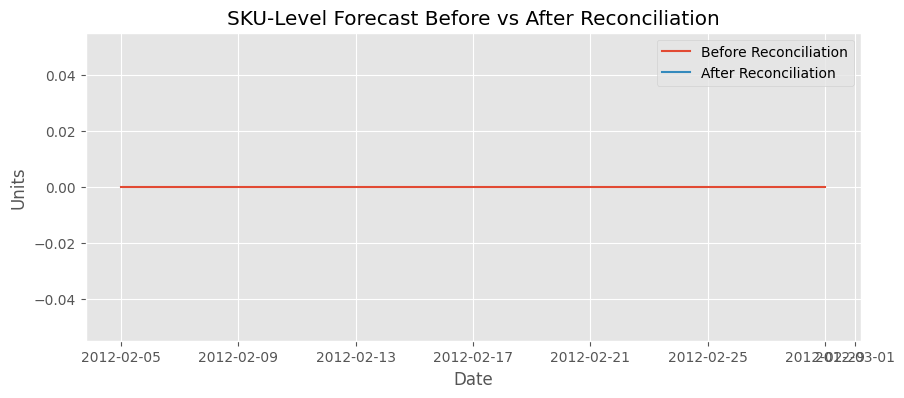

In [10]:
sample_sku = forecast_df["sku_store"].iloc[0]

plt.figure(figsize=(10, 4))

subset_before = forecast_df[forecast_df["sku_store"] == sample_sku]
subset_after = forecast_scaled[forecast_scaled["sku_store"] == sample_sku]

plt.plot(subset_before["date"], subset_before["p50"], label="Before Reconciliation")
plt.plot(subset_after["date"], subset_after["p50_reconciled"], label="After Reconciliation")

plt.legend()
plt.title("SKU-Level Forecast Before vs After Reconciliation")
plt.xlabel("Date")
plt.ylabel("Units")
plt.show()


## Saving Reconciled Forecasts

Reconciled forecasts were saved for use in
inventory optimization.


In [11]:
import os

os.makedirs("../outputs/forecasts", exist_ok=True)

forecast_scaled.to_csv(
    "../outputs/forecasts/reconciled_forecasts.csv",
    index=False
)


## Summary

In this notebook:

- Bottom-level probabilistic forecasts were aggregated upward
- Simple top-down reconciliation logic was applied
- Forecast coherence across hierarchy levels was validated
- Reconciled outputs were saved for downstream decision modeling

The next notebook converts reconciled forecasts
into inventory decisions.
